# **BirdCLEF 2025 Data Preprocessing Notebook**
This notebook demonstrates how we can transform audio data into mel-spectrogram data. This transformation is essential for training 2D Convolutional Neural Networks (CNNs) on audio data, as it converts the one-dimensional audio signals into two-dimensional image-like representations.
I run this public notebook in debug mode(only a few sample processing). You can find the fully preprocessed mel spectrogram training dataset here --> [BirdCLEF'25 | Mel Spectrograms](https://www.kaggle.com/datasets/kadircandrisolu/birdclef25-mel-spectrograms).


In [6]:
import cv2
import math
import time
import os
import librosa
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

In [10]:
class Config:
 
    DEBUG_MODE = False
    
    OUTPUT_DIR = 'archive'
    DATA_ROOT = 'birdclef-2025'
    SOUNDSCAPE_DIR = "birdclef-2025/train_soundscapes"
    FS = 32000
    
    # Mel spectrogram parameters
    N_FFT = 1024
    HOP_LENGTH = 512
    N_MELS = 128
    FMIN = 50
    FMAX = 14000
    
    TARGET_DURATION = 5.0
    TARGET_SHAPE = (256, 256)  
    
    N_MAX = 50 if DEBUG_MODE else None  

config = Config()

In [ ]:
print(f"Debug mode: {'ON' if config.DEBUG_MODE else 'OFF'}")
print(f"Max samples to process: {config.N_MAX if config.N_MAX is not None else 'ALL'}")

Debug mode: OFF
Max samples to process: ALL


In [42]:
filepaths = [f"{config.SOUNDSCAPE_DIR}"+"/"+f"{name}" for name in os.listdir(config.SOUNDSCAPE_DIR)]
working_df = pd.DataFrame({"filepath":filepaths})
working_df['samplename'] = working_df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])
total_samples = min(len(working_df), config.N_MAX or len(working_df))
with open('sample_list.csv', 'w') as f:
    working_df.to_csv(f)
print(f'Total samples to process: {total_samples} out of {len(working_df)} available')

Total samples to process: 9726 out of 9726 available


In [22]:
def audio2melspec(audio_data):
    if np.isnan(audio_data).any():
        mean_signal = np.nanmean(audio_data)
        audio_data = np.nan_to_num(audio_data, nan=mean_signal)

    mel_spec = librosa.feature.melspectrogram(
        y=audio_data,
        sr=config.FS,
        n_fft=config.N_FFT,
        hop_length=config.HOP_LENGTH,
        n_mels=config.N_MELS,
        fmin=config.FMIN,
        fmax=config.FMAX,
        power=2.0
    )

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)
    
    return mel_spec_norm

In [23]:
print("Starting audio processing...")
print(f"{'DEBUG MODE - Processing only 50 samples' if config.DEBUG_MODE else 'FULL MODE - Processing all samples'}")
start_time = time.time()

all_bird_data = {}
errors = []

for i, row in tqdm(working_df.iterrows(), total=total_samples):
    if config.N_MAX is not None and i >= config.N_MAX:
        break
    
    try:
        audio_data, _ = librosa.load(row.filepath, sr=config.FS)

        target_samples = int(config.TARGET_DURATION * config.FS)

        if len(audio_data) < target_samples:
            n_copy = math.ceil(target_samples / len(audio_data))
            if n_copy > 1:
                audio_data = np.concatenate([audio_data] * n_copy)

        start_idx = max(0, int(len(audio_data) / 2 - target_samples / 2))
        end_idx = min(len(audio_data), start_idx + target_samples)
        center_audio = audio_data[start_idx:end_idx]

        if len(center_audio) < target_samples:
            center_audio = np.pad(center_audio, 
                                 (0, target_samples - len(center_audio)), 
                                 mode='constant')

        mel_spec = audio2melspec(center_audio)

        if mel_spec.shape != config.TARGET_SHAPE:
            mel_spec = cv2.resize(mel_spec, config.TARGET_SHAPE, interpolation=cv2.INTER_LINEAR)

        all_bird_data[row.samplename] = mel_spec.astype(np.float32)
        
    except Exception as e:
        print(f"Error processing {row.filepath}: {e}")
        errors.append((row.filepath, str(e)))

end_time = time.time()
print(f"Processing completed in {end_time - start_time:.2f} seconds")
print(f"Successfully processed {len(all_bird_data)} files out of {total_samples} total")
print(f"Failed to process {len(errors)} files")

Starting audio processing...
FULL MODE - Processing all samples


  0%|          | 0/9726 [00:00<?, ?it/s]

Processing completed in 832.55 seconds
Successfully processed 9726 files out of 9726 total
Failed to process 0 files


In [29]:
# Save the processed data
output_dir = config.OUTPUT_DIR
filename = "train_soundscapes_mel_spec_5_256_256.npy"
with open(f"{output_dir}/{filename}", 'wb') as f:
    np.save(f, all_bird_data)
print(f"Processed data saved to {output_dir}/{filename}")

Processed data saved to archive/train_soundscapes_mel_spec_5_256_256.npy


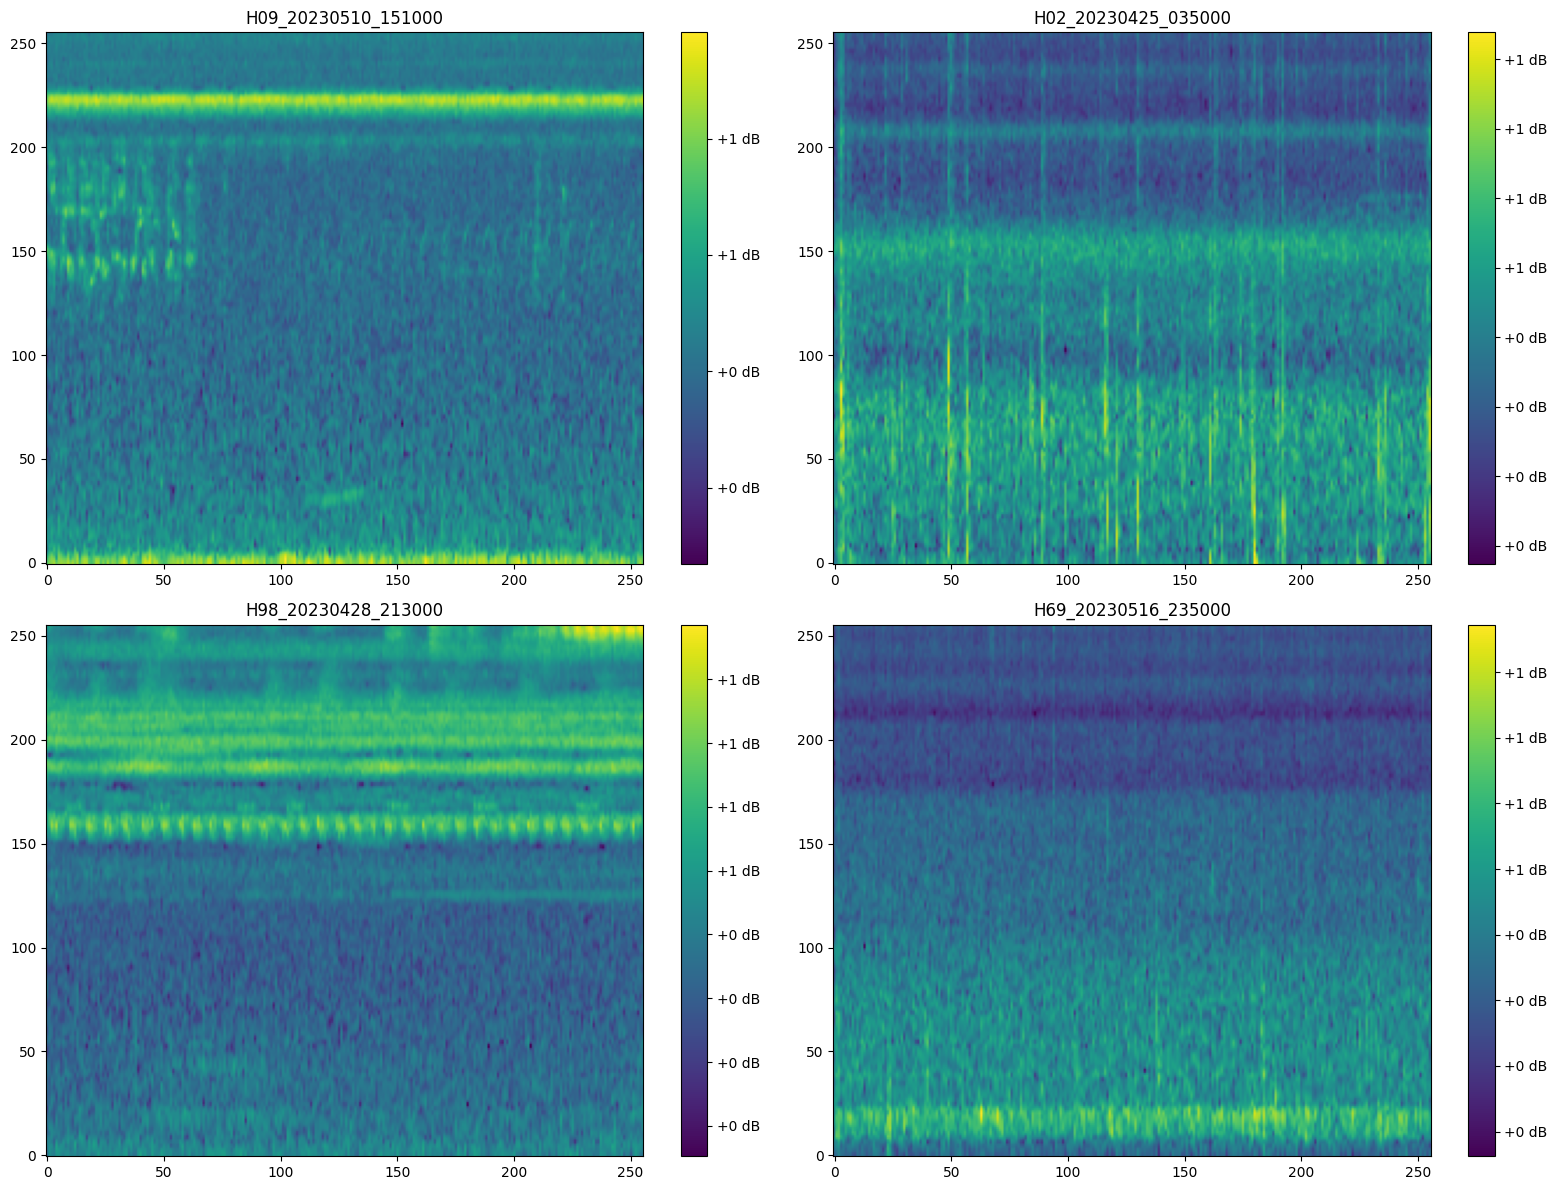

In [27]:
import matplotlib.pyplot as plt

samples = []

max_samples = min(4, len(all_bird_data))

for i, row in working_df.iterrows():
    if i >= (config.N_MAX or len(working_df)):
        break
        
    if row['samplename'] in all_bird_data:
        samples.append(row['samplename'])
        
        if len(samples) >= max_samples:  
            break

if samples:
    plt.figure(figsize=(16, 12))
    
    for i, samplename in enumerate(samples):
        plt.subplot(2, 2, i+1)
        plt.imshow(all_bird_data[samplename], aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"{samplename}")
        plt.colorbar(format='%+2.0f dB')
    
    plt.tight_layout()
    debug_note = "debug_" if config.DEBUG_MODE else ""
    plt.savefig(f'{debug_note}melspec_examples.png')
    plt.show()